<a href="https://colab.research.google.com/github/masa512/harmonics_percussion/blob/main/percussive_harmonic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import librosa
from librosa.feature import melspectrogram
from librosa.feature.inverse import mel_to_audio
from librosa.display import specshow
from IPython.display import Audio
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.io.wavfile import write


In [4]:
# Read the audio file

dir = 'ensemble.mp3'
data, fs = sf.read(dir)
L = len(data)
t = 1/fs * np.arange(L)


Text(0.5, 0, 'Time (s)')

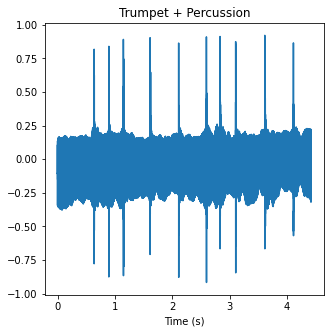

In [6]:
# Plot the audio
f = plt.figure(figsize=(5,5))
plt.plot(t,data)
plt.title('Trumpet + Percussion')
plt.xlabel('Time (s)')


Text(0.5, 1.0, 'Mel-spectrogram of Data')

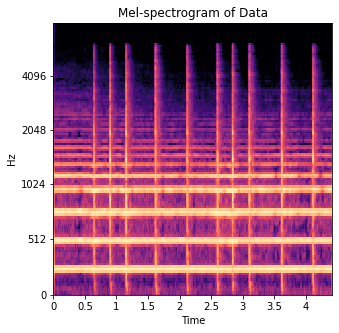

In [8]:
# Take STFT for representation
S = librosa.stft(data)

# Also take the Mel spectrogram of data
f,ax = plt.subplots(figsize=(5,5))
fmax = 8000
S_mel = melspectrogram(data,sr=fs)
S_dB = librosa.power_to_db(S_mel, ref=np.max)
img = specshow(S_dB, x_axis='time', y_axis='mel', sr=fs, fmax=fmax, ax=ax)
ax.set_title('Mel-spectrogram of Data')

We see the crossing of vertical and horizontal lines. According to the previous findings, 

1. The percussive sounds are represented by the straight vertical line meaning a small impulse (thus wide frequency coverage)
2. The harmonic sounds are represented by the straight horizontal lines meaning monotonic, steady sound over time

# Iterative optimization

In [13]:
class harmperc_sep():

  def __init__(self,gamma,alpha):
    """
    gamma : power in range [0,1]
    alpha : regularization in range [0,1]
    """
    self.gamma = gamma
    self.alpha = alpha
  
  def load_data(self,S):
    """
    Initialize separation with data
    """
    self.S = S
    self.W = abs(S)**(2*self.gamma)
    self.H = 1/2*self.W
    self.P = self.H
  
  def optimize(self,T):

    # The main loop
    for t in range(T):
      # pad H and P each by 1 all directions
      H1 = np.pad(self.H,pad_width = ((1,1),(1,1)), constant_values=((0,0),(0,0)))
      P1 = np.pad(self.P,pad_width = ((1,1),(1,1)), constant_values=((0,0),(0,0)))

      # evaluate delta
      dH = 1/4*(np.roll(H1,1,1)-2*H1+np.roll(H1,-1,1))
      dP = 1/4*(np.roll(P1,1,0)-2*P1+np.roll(P1,-1,0))
      D = self.alpha * dH - (1-self.alpha) * dP
      D = D[1:-1,1:-1]

      # update H and P
      self.H = np.maximum(self.H + D,np.zeros_like(D))
      self.H = np.minimum(self.W,self.H)

      self.P = self.W - self.H

    # Binarize
    H = np.zeros_like(self.H)
    H[self.H>self.P] = self.W[self.H>self.P]

    P = np.zeros_like(self.P)
    P[self.P>=self.P] = self.W[self.P>=self.P]

    # Recover the time domain signal
    h = librosa.istft((self.H)**(1/(2*self.gamma))*np.exp(1j*np.angle(self.S)))
    p = librosa.istft((self.P)**(1/(2*self.gamma))*np.exp(1j*np.angle(self.S)))

    return h,p


In [34]:
# Initiate Model
gamma = 0.5
alpha = 1
model = harmperc_sep(gamma,alpha)

# Load the data into the model
model.load_data(S)

# Optimize
T = 30
h,p = model.optimize(T)

In [35]:
# Save the audio 
write('hamonic.mp3', fs, h)
write('percussion.mp3', fs, p)

In [36]:
# Play the audio
w =  Audio('percussion.mp3', autoplay=True)
display(w)